# Memorability Classifier

#### Dataset: VISCHEMA PLUS
#### Dataset image shape: (3x700x700)
#### Dataset label shape: (3x700x700)
#### Dataset label format:
VMS map. It is a 3x700x700 image that is mostly black, the image outputted is a representation of the most memorable locations in the input.

#### Model Plan
I think a U-net would be best here. I will have to learn how to use skip connections.

#### Loss function considerations:
Maybe squared difference between every pixel in the expected output vs the predicted output. This might be computationally expensive.

In [1]:
# Import the required libraries

import torch
import os
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torch.nn.functional import interpolate
import torch.nn as nn
import math
import numpy as np
from natsort import natsorted
from PIL import Image

#### Dataclass and Dataloaders
I need to create a custom dataclass because the labels are more complex than strings. I have called this VISCHEMA_PLUS. I tried to load all of the images into memory at initialisation but that caused my laptop to run out of memory. Instead I will load an image when it is called by the `__getitem__` method.

In [2]:
class VISCHEMA_PLUS(Dataset):
    def __init__(self, image_dir = 'VISCHEMA_PLUS/images', label_dir = 'VISCHEMA_PLUS/vms', transform = None):
        self.transform = transform
        
        self.image_dir = image_dir
        self.label_dir = label_dir
        
        all_images = os.listdir(image_dir)
        self.all_images = natsorted(all_images)
        
    def __len__(self):
        return len(self.all_images)

    def __getitem__(self, idx):    
        convert_tensor = transforms.ToTensor()
        
        image = Image.open(f"{self.image_dir}/{self.all_images[idx]}").convert("RGB")
        image = convert_tensor(image)

        label = Image.open(f"{self.label_dir}/{self.all_images[idx]}").convert("RGB")
        label = convert_tensor(label)
        
        if self.transform != None:
            image = self.transform(image)
            label = self.transform(label)
            
        return image, label

# I have resized the images to 512x512 as this will make designing the model easier.
image_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.Normalize(0.5,0.5)
])
        
dataset = VISCHEMA_PLUS(transform = image_transforms)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

batch_size = 4
train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle=True)

print(f'{len(train_dataset)} Items in Train dataset')
print(f'{len(test_dataset)}  Items in Test dataset')

1280 Items in Train dataset
320  Items in Test dataset


#### Test that the images and labels look good

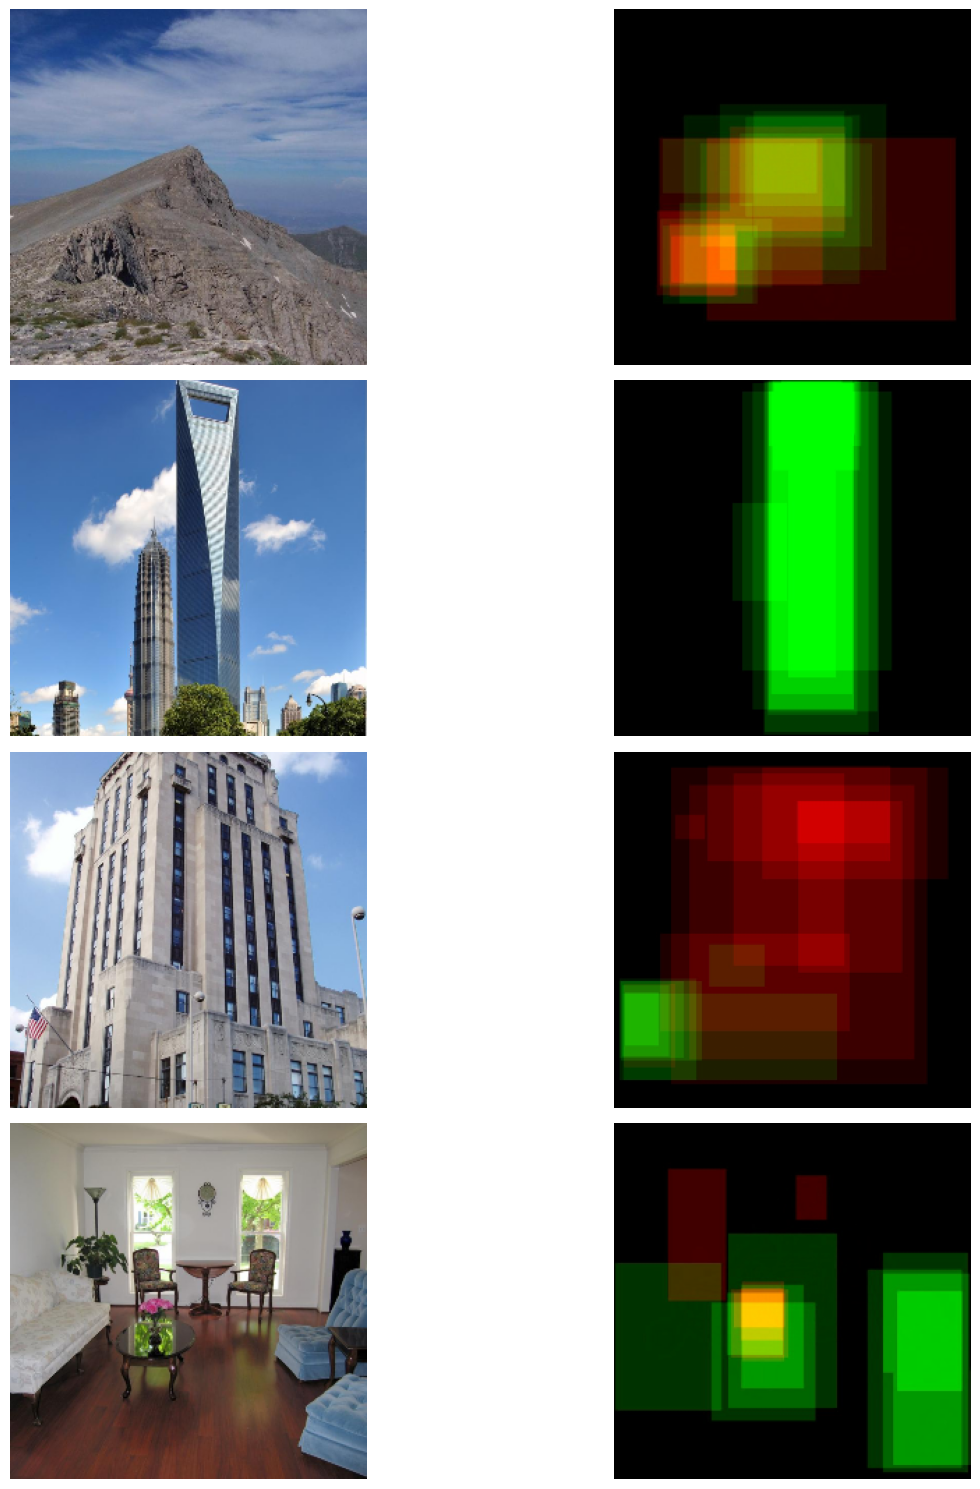

In [3]:
import matplotlib.pyplot as plt

images, labels = next(iter(train_loader))
figure = plt.figure(figsize=(15,15))
cols, rows = 1, 4
for i in range(cols * rows):
    figure.add_subplot(rows,cols*2, 2*i+1)
    plt.axis("off")
    plt.imshow((images[i,:].squeeze().permute(1, 2, 0) +1 )/2 )
    figure.add_subplot(rows,cols*2, 2*i+2)
    plt.axis("off")
    plt.imshow((labels[i,:].squeeze().permute(1, 2, 0) +1 )/2 )
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

images, labels = next(iter(train_loader))
figure = plt.figure(figsize=(15,15))
cols, rows = 1, 4

combined = transforms.functional.adjust_brightness(np.add(images, labels) ,1.0)
#combined = combined*0.5

for i in range(cols * rows):
    figure.add_subplot(rows,cols*3, 3*i+1)
    plt.axis("off")
    plt.imshow((images[i,:].squeeze().permute(1, 2, 0) +1 )/2 )
    figure.add_subplot(rows,cols*3, 3*i+2)
    plt.axis("off")
    plt.imshow((labels[i,:].squeeze().permute(1, 2, 0) +1 )/2 )
    figure.add_subplot(rows,cols*3, 3*i+3)
    plt.axis("off")
    plt.imshow((combined[i,:].squeeze().permute(1, 2, 0) +1 )/ 2 )  
plt.tight_layout()
plt.show()

#### Creating Models
There isn't a lot of data so maybe transfer learning would be a better idea but first I want to make my own models so that I can at least track some improvement.

I want to automatically test a range of models and train them all with various hyperparameters. I will create a range of models, a function that returns an instanciated copy of each model in a list, loop over that list along with all of the hyperparameters that I want to tune, and save the results in a `.txt` file.

## Classic UNet

In [120]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,3),
            nn.ReLU(),
            nn.Conv2d(out_channels,out_channels,3),
            nn.ReLU(),
        )
    def forward(self, x):
        return self.main(x)
    
class Encoder(nn.Module):
    def __init__(self, channels=(3,64,128,256,512,1024)):
        super().__init__()
        self.encoding_blocks = nn.ModuleList(
            [Block(channels[i], channels[i+1]) for i in range(len(channels)-1)]
        )
        self.pool = nn.MaxPool2d(2)
    
    def forward(self, x):
        features = []
        
        for block in self.encoding_blocks:
            x = block(x)
            features.append(x)
            x = self.pool(x)
                 
        return features
        
class Decoder(nn.Module):
    def __init__(self, channels=(1024, 512, 256, 128, 64)):
        super().__init__()
        self.channels = channels
        self.upconvs = nn.ModuleList([nn.ConvTranspose2d(self.channels[i], self.channels[i+1],2,2) for i in range(len(channels)-1)])
        self.decoder_blocks = nn.ModuleList(
            [Block(channels[i], channels[i+1]) for i in range(len(channels)-1)]
        )
    
    def forward(self, x, encoder_features):
        for i in range(len(self.channels)-1):
            x = self.upconvs[i](x)
            features = self.crop(encoder_features[i], x)
            x = torch.cat([x, features], dim=1)
            x = self.decoder_blocks[i](x)
        return x
    
    def crop(self, features, x):
        _, _, height, width = x.shape
        features = transforms.CenterCrop([height, width])(features)
        return features
        
class UNet(nn.Module):
    def __init__(self, 
                 encode_channels=(3,64,128,256,512,1024), 
                 decode_channels=(1024, 512, 256, 128, 64), 
                 num_class=3, 
                 retain_dim=True, 
                 output_size=(572,572)):
        
        super(UNet, self).__init__()
        
        self.encoder = Encoder(encode_channels)
        self.decoder = Decoder(decode_channels)
        
        self.head = nn.Conv2d(decode_channels[-1], num_class, 1)
        self.retain_dim = retain_dim
        self.output_size = output_size
        
        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.ConvTranspose2d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)


    def forward(self, x):
        encoding_features = self.encoder(x)
        decoding_features = self.decoder(encoding_features[::-1][0], encoding_features[::-1][1:])
        output = self.head(decoding_features)
        if self.retain_dim:
            output = interpolate(output, self.output_size)
        output = torch.clamp(output, -1,1)
        return output

images, _ = next(iter(train_loader))
_ , _ , height, width = images.shape
model = UNet(retain_dim=True, output_size=(height,width))

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_params} Parameters in UNet')

output = model(images)
print(output.shape)

31031875 Parameters in UNet
torch.Size([4, 3, 256, 256])


## Lets see what the default outputs look like
<i> I expect this to be noise <i>

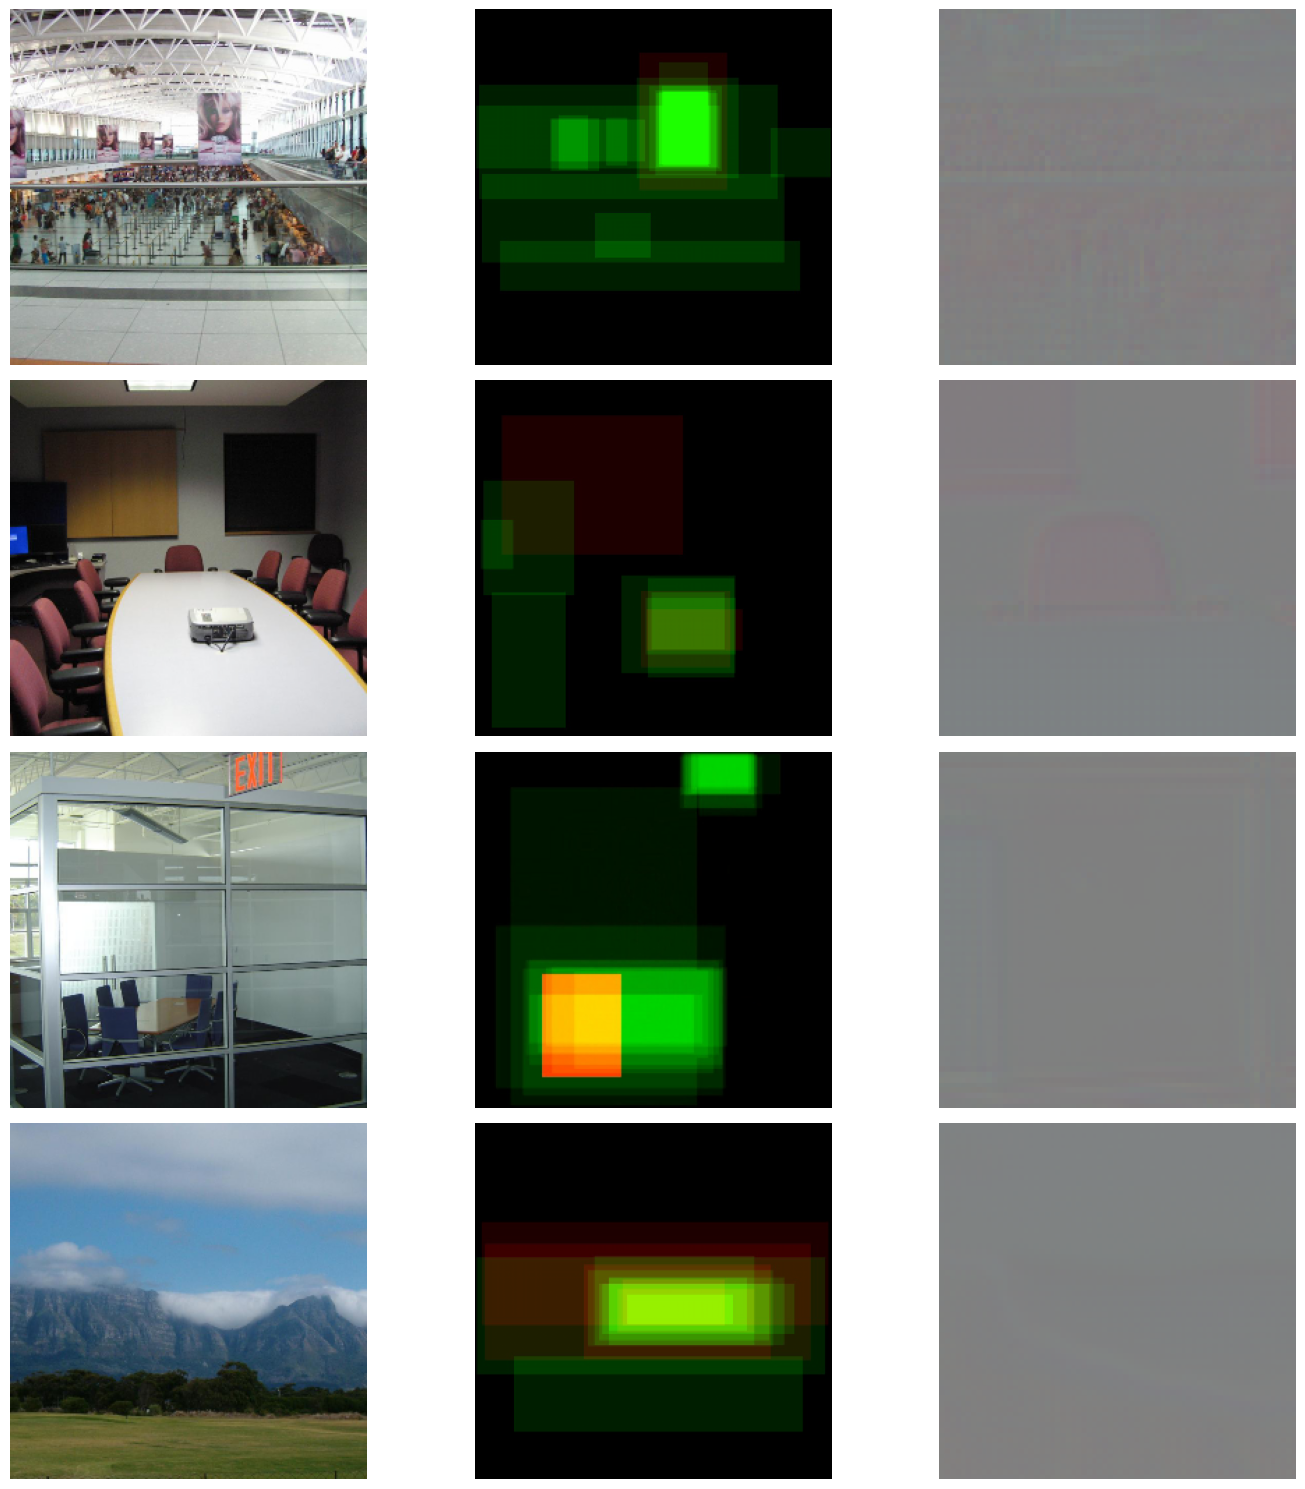

In [117]:
import matplotlib.pyplot as plt

images, labels = next(iter(train_loader))
figure = plt.figure(figsize=(15,15))
output = model(images)

cols, rows = 1, 4
for i in range(cols * rows):
    figure.add_subplot(rows,cols*3, 3*i+1)
    plt.axis("off")
    plt.imshow((images[i,:].cpu().detach().squeeze().permute(1, 2, 0) +1 )/ 2 )
    figure.add_subplot(rows,cols*3, 3*i+2)
    plt.axis("off")
    plt.imshow((labels[i,:].cpu().detach().squeeze().permute(1, 2, 0) +1 )/ 2 )
    figure.add_subplot(rows,cols*3, 3*i+3)
    plt.axis("off")
    plt.imshow((output[i,:].cpu().detach().squeeze().permute(1, 2, 0) +1 )/ 2 )  
plt.tight_layout()
plt.show()

### Test what images look like with the VMS applied ontop of it

In [121]:
# Set up our training environment
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

images, _ = next(iter(train_loader))
_ , _ , height, width = images.shape
model = UNet(retain_dim=True, output_size=(height,width))
model = model.to(device)

# initialize loss function and optimizer
def dice_loss(pred, target, weights = [1,2,1]):
    
    pred, target = (pred+1)/2, (target+1)/2
    
    weights = torch.tensor(weights).to(device)
    weights = weights.view(1,3,1,1)
    weights = weights.expand_as(pred)
    
    pred = pred * weights
    pred = pred.view(-1)
    target = target * weights
    target = target.view(-1)
    
    intersection = (pred * target).sum()
    denominator = torch.clamp(pred.sum() + target.sum(), min=1e-15)
    loss = (1 - (2. * intersection) / denominator)

    return loss

# Not sure if reduction should be none, mean, or sum.
# Test all 3?
loss_func = nn.L1Loss(reduction = 'none')

optim = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 40

images, labels = next(iter(train_loader))
images, labels = images.to(device), labels.to(device)
output = model(images)
loss = loss_func(output,labels)
print(loss)

tensor(-3.0309, device='cuda:0', grad_fn=<DivBackward1>)


In [122]:
# These variables will store the data for analysis
training_losses = []
test_losses = []

print('Starting Training')

for epoch in range(num_epochs):
    
    # Go into training mode
    model.train()
    
    # Train the model and evaluate on the training set
    total_train_loss = 0
    total_test_loss = 0

    for i, (images, labels) in enumerate(train_loader):
    
        #Move images to device and create an image prediction
        images, labels = images.to(device), labels.to(device)
        output = model(images)
    
        #Evaluate the loss of our model and take a step
        loss = loss_func(output,labels)
        optim.zero_grad()
        loss.backward()
        optim.step()

        total_train_loss += loss*images.shape[0]
        torch.cuda.empty_cache()

    total_train_loss /= len(train_dataset)
    training_losses.append(total_train_loss.to("cpu"))

    # Evaluate the model on the test set
    # Reset counters and switch to eval mode
    model.eval()

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = loss_func(output,labels)
            total_test_loss += loss*images.shape[0]

        total_test_loss /= len(test_dataset)

    # save counters
    test_losses.append(total_test_loss.item()) 
    
    print(f'Epoch [{epoch + 1}],Train Loss: {total_train_loss}, Test Loss: {total_test_loss}')

Starting Training
Epoch [1],Train Loss: -4.321983814239502, Test Loss: -4.348073482513428
Epoch [2],Train Loss: -4.331298351287842, Test Loss: -4.348073482513428
Epoch [3],Train Loss: -4.331298351287842, Test Loss: -4.3480730056762695
Epoch [4],Train Loss: -4.331297397613525, Test Loss: -4.348073482513428
Epoch [5],Train Loss: -4.331297874450684, Test Loss: -4.3480730056762695


KeyboardInterrupt: 

[tensor(-4.3220, grad_fn=<ToCopyBackward0>), tensor(-4.3313, grad_fn=<ToCopyBackward0>), tensor(-4.3313, grad_fn=<ToCopyBackward0>), tensor(-4.3313, grad_fn=<ToCopyBackward0>), tensor(-4.3313, grad_fn=<ToCopyBackward0>)]
[-4.348073482513428, -4.348073482513428, -4.3480730056762695, -4.348073482513428, -4.3480730056762695]


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

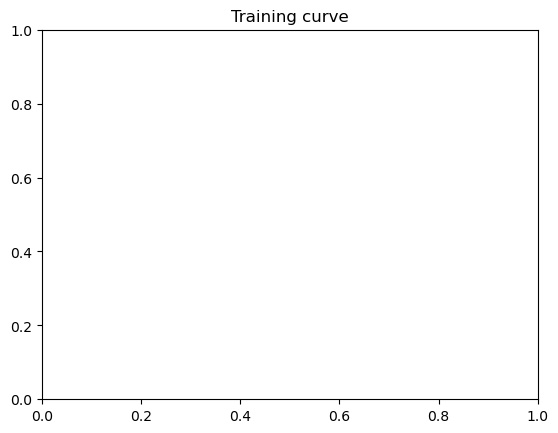

In [123]:
plt.title("Training curve")

print(training_losses)
print(test_losses)
plt.plot(range(len(training_losses)),training_losses,'r')
plt.plot(range(len(test_losses)),test_losses,'g')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [ ]:
torch.save(model.state_dict(), 'weights.pkl')

IndexError: index 4 is out of bounds for dimension 0 with size 4

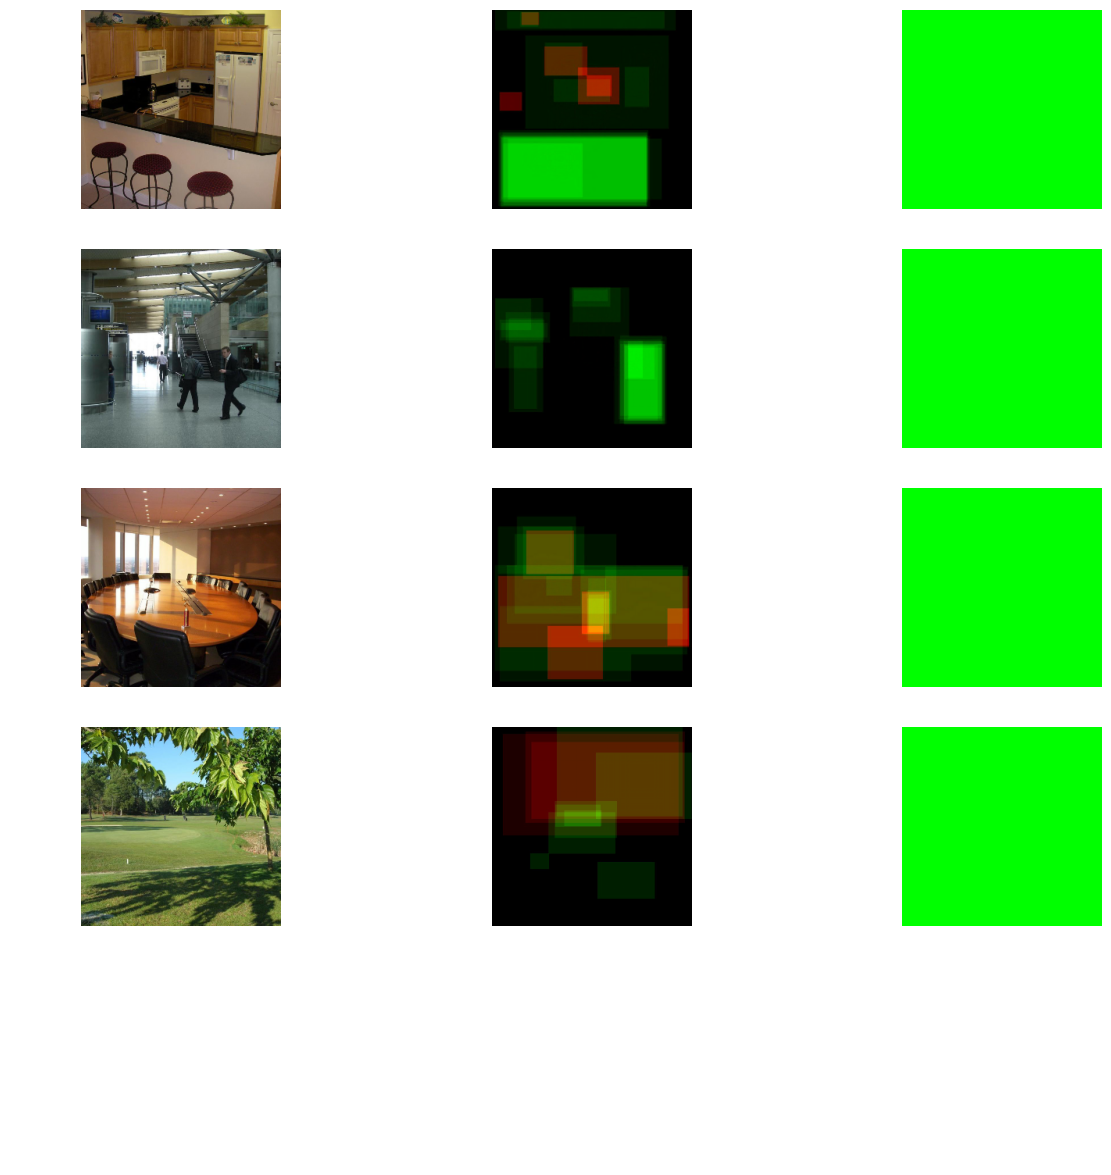

In [124]:
import matplotlib.pyplot as plt

images, labels = next(iter(train_loader))
images, labels = images.to(device), labels.to(device)
figure = plt.figure(figsize=(15,15))
output = model(images)
cols, rows = 1, 4
for i in range(cols * rows):
    figure.add_subplot(rows,cols*3, 3*i+1)
    plt.axis("off")
    plt.imshow((images[i,:].cpu().detach().squeeze().permute(1, 2, 0) +1 )/2 )
    figure.add_subplot(rows,cols*3, 3*i+2)
    plt.axis("off")
    plt.imshow((labels[i,:].cpu().detach().squeeze().permute(1, 2, 0) +1 )/2 )
    figure.add_subplot(rows,cols*3, 3*i+3)
    plt.axis("off")
    plt.imshow((output[i,:].cpu().detach().squeeze().permute(1, 2, 0) +1 )/2 )
    
plt.tight_layout()
plt.show()